In [1]:
! pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

# Adjustment set with 1 variable

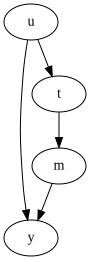

In [3]:
fd0 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.3,0.7), (1,): (0.9,0.1)}),       
    # (0,): (0.5,0.5) means the following
    # given the value of input "0" (in this case we have only 1 input variable "u"), 
    # the resulting descrete values are generated with certain probability: 
    # 0 with probability 0.5 and 1 with probability 0.5
    "m": discrete_model(["t"], {(0,): (0.9, 0.1), (1,): (0.2, 0.8)}),
    "y": discrete_model(["m", "u"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.4, 0.6),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.7, 0.3),
    }),
    # (0, 0): (0.95, 0.05), means the following
    # given the value of input "0, 0" (in this case we have 2 input variables  "z" and "u"), 
    # the resulting descrete values are generated with certain probability: 
    # 0 with probability 0.95 and 1 with probability 0.05
})

fd0.cgm.draw()

In [4]:
fd0.cgm.get_all_frontdoor_adjustment_sets('t', 'y')

frozenset({frozenset({'m'})})

Estimate the true causal effect with a simulation of an experiment.

- Use 500000 instances of each value of treatment for estimation
- Perform estimation 10 times and round the result

Your solution

* First I defined a funsction to get the samples and the ate every time, because it should be done 10 times, then I append them all to an empty list in order to get the mean and round it:

In [5]:
df = fd0.sample(n_samples=10000)

In [6]:
def estimation():
  set_variable_t = np.array([0]*500000 + [1]*500000)
  ab_test_df = fd0.do('t').sample(
                    set_values={'t': set_variable_t}, 
                    n_samples=len(set_variable_t))
  ate_ = ab_test_df[ab_test_df["t"] == 1]["y"].mean() - ab_test_df[ab_test_df["t"] == 0]["y"].mean()
  return ate_

In [7]:
estimation()

-0.38586799999999993

In [8]:
L = []
for i in range(0,10):
  L.append(estimation())
  ate = np.mean(L)
print("The true causal effect after 10 times estimation is {}".format(ate))

The true causal effect after 10 times estimation is -0.3850742


Estimate ATE using frontdoor adjustment:

$ATE = E[Y|do(t=1)] - E[Y|do(t=0)]$

$E[Y|do(t)] = \sum_m P(m| t) \sum_{t'} E[Y|m, t'] P(t')$

Sample 1000000 observations from the model for calculations.

Compare your estimation with the true causal effect.

$E[Y|do(t=1)] = \sum_m P(m| t=1) \sum_{t'} E[Y|m, t'] P(t')$

$E[Y|do(t=1)] = \sum_m P(m| t=1) ( E[Y|m, t'=0] P(t'=0) + E[Y|m, t'=1] P(t'=1))$

$E[Y|do(t=1)] =  P(m=0| t=1) \left[ E[Y|m=0, t'=0] P(t'=0) + E[Y|m=0, t'=1] P(t'=1)\right] + P(m=1| t=1) \left[ E[Y|m=1, t'=0] P(t'=0) + E[Y|m=1, t'=1] P(t'=1)\right]$

**E[Y|do(t=1)]**

* a1 = P(m=0|t=1)[E[Y|m=0,t′=0]P(t′=0)



In [9]:
a1 = (len(df[(df["m"] == 0) & (df["t"] == 1)]) /len(df[df["t"] == 1])) *  (df[(df["m"] == 0) & (df["t"] == 0)]["y"].mean()) * (len(df[df["t"] == 0])/len(df))

In [10]:
a1

0.08350583877999479

* b1 = P(m=0|t=1)E[Y|m=0,t′=1]P(t′=1)]

In [11]:
b1 = (len(df[(df["m"] == 0) & (df["t"] == 1)]) /len(df[df["t"] == 1])) * (df[(df["m"] == 0) & (df["t"] == 1)]["y"].mean()) * (len(df[df["t"] == 1])/len(df))

In [12]:
b1

0.0701

* c1 = P(m=1|t=1)[E[Y|m=1,t′=0]P(t′=0)

In [13]:
c1 = (len(df[(df["m"] == 1) & (df["t"] == 1)]) /len(df[df["t"] == 1])) *  (df[(df["m"] == 1) & (df["t"] == 0)]["y"].mean()) * (len(df[df["t"] == 0])/len(df))

In [14]:
c1

0.13012420945389613

* d1 = P(m=1|t=1)d = E[Y|m=1,t′=1]P(t′=1)]

In [15]:
d1 = (len(df[(df["m"] == 1) & (df["t"] == 1)]) /len(df[df["t"] == 1])) * (df[(df["m"] == 1) & (df["t"] == 1)]["y"].mean()) * (len(df[df["t"] == 1])/len(df))

In [16]:
d1

0.041199999999999994

In [17]:
do1 = a1+b1+c1+d1

In [18]:
do1

0.32493004823389093

* **E[Y|do(t=0)]**

* a0 = P(m=0|t=0)[E[Y|m=0,t′=0]P(t′=0)

In [19]:
a0 = (len(df[(df["m"] == 0) & (df["t"] == 0)]) /len(df[df["t"] == 0])) *  (df[(df["m"] == 0) & (df["t"] == 0)]["y"].mean()) * (len(df[df["t"] == 0])/len(df))

In [20]:
a0

0.36640000000000006

* b0 = P(m=0|t=0)E[Y|m=0,t′=1]P(t′=1)]

In [21]:
b0 = (len(df[(df["m"] == 0) & (df["t"] == 0)]) /len(df[df["t"] == 0])) * (df[(df["m"] == 0) & (df["t"] == 1)]["y"].mean()) * (len(df[df["t"] == 1])/len(df))

In [22]:
b0

0.3075789714258062

* c0 = P(m=1|t=0)[E[Y|m=1,t′=0]P(t′=0)

In [23]:
c0 = (len(df[(df["m"] == 1) & (df["t"] == 0)]) /len(df[df["t"] == 0])) *  (df[(df["m"] == 1) & (df["t"] == 0)]["y"].mean()) * (len(df[df["t"] == 0])/len(df))

In [24]:
c0

0.0158

* d0 = P(m=1|t=0)d = E[Y|m=1,t′=1]P(t′=1)]

In [25]:
d0 = (len(df[(df["m"] == 1) & (df["t"] == 0)]) /len(df[df["t"] == 0])) * (df[(df["m"] == 1) & (df["t"] == 1)]["y"].mean()) * (len(df[df["t"] == 1])/len(df))

In [26]:
d0

0.005002604839882924

In [27]:
do0 = a0 + b0 + c0 + d0

In [28]:
do0

0.6947815762656891

In [29]:
do1 - do0

-0.3698515280317982

Answers for intermediate steps

`Probabilities of t: [0.600145, 0.39985499999999996]`

`Probabilities of m|t=0: [0.8997425622141316, 0.10025743778586838]`

`Probabilities of m|t=1: [0.20083030098410673, 0.7991696990158933]`

`E_y_0_0 = 0.674442938204661`

`E_y_0_1 = 0.8632180615917213`

`E_y_1_0 = 0.2503282421180342`

`E_y_1_1 = 0.674442938204661`

`E[Y|do(t=1) = 0.31053464249294344`

`E[Y|do(t=0) = 0.694803138475164`

`ate = -0.3842684959822205`

`Error: 0.276%`

# Adjustment set with 2 variables

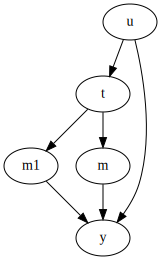

In [30]:
fd2 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.3, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.1,0.9), (1,): (0.8,0.2)}),
    "m": discrete_model(["t"], {(0,): (0.7, 0.3), (1,): (0.1, 0.9)}),
    "m1": discrete_model(["t"], {(0,): (0.6, 0.4), (1,): (0.45, 0.55)}),
    "y": discrete_model(["m", "m1", "u"], {
        (0, 0, 0): (0.2, 0.8), 
        (0, 0, 1): (0.1, 0.9),
        (0, 1, 0): (0.6, 0.4), 
        (0, 1, 1): (0.4, 0.6),
        (1, 0, 0): (0.7, 0.3), 
        (1, 0, 1): (0.8, 0.2),
        (1, 1, 0): (0.8, 0.2), 
        (1, 1, 1): (0.7, 0.3),
    }),
})

fd2.cgm.draw()

Do the same for the model with the adjustment set containing 2 variables.

Hint, you can consider the case with 1 variable in the adjustment set, but the new variable now has 4 possible values: 
(0,0), (0,1), (1,0), (1,1).

Your solution

E[Y|do(t=1)]=

P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=0]P(t′=0)+E[Y|m=0,m1=0,t′=1]P(t′=1)]+

P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=0]P(t′=0)+E[Y|m=1,m1=0,t′=1]P(t′=1)]+

P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=0]P(t′=0)+E[Y|m=0,m1=1,t′=1]P(t′=1)]+

P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=0]P(t′=0)+E[Y|m=1,m1=1,t′=1]P(t′=1)]

In [31]:
df2 = fd2.sample(n_samples=100000)

* a1_0 = P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=0]P(t′=0)]

In [32]:
a1_0 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 0) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 0) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* a1_1 = P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=1]P(t′=1)]

In [33]:
a1_1 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 0) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 0) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

* b1_0 = P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=0]P(t′=0)]

In [34]:
b1_0 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 0) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 0) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* b1_1 = P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=1]P(t′=1)]

In [35]:
b1_1 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 0) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 0) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

* c1_0 = P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=0]P(t′=0)]

In [36]:
c1_0 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 1) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 1) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* c1_1 = P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=1]P(t′=1)]

In [37]:
c1_1 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 1) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 1) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

* d1_0 = P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=0]P(t′=0)

In [38]:
d1_0 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 1) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 1) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* d1_1 = P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=1]P(t′=1)

In [39]:
d1_1 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 1) & (df2["t"] == 1)]) /len(df2[df2["t"] == 1])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 1) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

In [40]:
do_1 = a1_0 + a1_1 + b1_0 + b1_1 + c1_0 + c1_1 + d1_0 + d1_1
do_1

0.28323013055495094

E[Y|do(t=0)]=

P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=0]P(t′=0)+E[Y|m=0,m1=0,t′=1]P(t′=1)]+

P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=0]P(t′=0)+E[Y|m=1,m1=0,t′=1]P(t′=1)]+

P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=0]P(t′=0)+E[Y|m=0,m1=1,t′=1]P(t′=1)]+

P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=0]P(t′=0)+E[Y|m=1,m1=1,t′=1]P(t′=1)]

* a0_0 = P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=0]P(t′=0)]

In [41]:
a0_0 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 0) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 0) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* a0_1 = P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=1]P(t′=1)]

In [42]:
a0_1 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 0) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 0) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

* b0_0 = P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=0]P(t′=0)]

In [43]:
b0_0 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 0) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 0) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* b0_1 = P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=1]P(t′=1)]

In [44]:
b0_1 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 0) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 0) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

* c0_0 = P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=0]P(t′=0)]

In [45]:
c0_0 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 1) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 1) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* c0_1 = P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=1]P(t′=1)]

In [46]:
c0_1 = (len(df2[(df2["m"] == 0) & (df2["m1"] == 1) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 0) & (df2["m1"] == 1) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

* d0_0 = P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=0]P(t′=0)

In [47]:
d0_0 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 1) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 1) &(df2["t"] == 0)]["y"].mean()) * (len(df2[df2["t"] == 0])/len(df2))

* d0_1 = P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=1]P(t′=1)

In [48]:
d0_1 = (len(df2[(df2["m"] == 1) & (df2["m1"] == 1) & (df2["t"] == 0)]) /len(df2[df2["t"] == 0])) *  (df2[(df2["m"] == 1) & (df2["m1"] == 1) &(df2["t"] == 1)]["y"].mean()) * (len(df2[df2["t"] == 1])/len(df2))

In [49]:
do_0 = a0_0 + a0_1 + b0_0 + b0_1 + c0_0 + c0_1 + d0_0 + d0_1
do_0

0.5532531608172335

In [50]:
do_1 - do_0

-0.2700230302622826

# Assignment

1. Implement a function for calculating ATE using front-door adjustment for an arbitrary number of adjusting variables. You can assume that all variables are binary. 

2. Compare your results with back-door adjustment. Note, that we assumed variable 𝑈 to be unobserved, however it is not.

3. Demostrate your code for 1, 2 and 3 (or more) adjusting variables.

*Answer: Here for an arbitary number of adjusting variables, I wrote a function which takes the model as input and gives the ATE using frontdoor adjustment as output.

In [51]:
import itertools as it

In [52]:
def cond_exp(df,f,t,j): #A function to calculate the conditional expectation from a df,front_door_set, t, and a possible combination of the adjustment set
  L= []
  a=""
  for i in range(0,len(f)):
    if i < len(f) - 1: #making the string of condition on dataframe
      a += f"{f[i]} == {j[i]} and "
    else:
      a += f"{f[i]} == {j[i]}" #For the last one we do not need 'and'
  L.append(a)
  L = [ f"t == {t} and " + i for i in L]  #Adding t = 0 or t = 1
  return df.query(L[0])["y"].mean() #Finding the mean

In [53]:
def ate_frontdoor(model, t, y):
  df = model.sample(10000)
  L = model.cgm.get_all_frontdoor_adjustment_sets('t', 'y')
  for i in L:
    front_door_sets = list(i) #get the list of all adjustment sets
    possible_comb = list(it.product([0, 1], repeat=len(front_door_sets))) #get the list of all possible combinations of 0 and 1
    y_unique = np.unique(df[y].values, axis=0)    
    
    #P(t)
    p_t = {i: len(df[df[t] == i])/len(df) for i in (0,1)} 
    #gives a dictionary with 0 and 1 as keys and probabilities of t=0 and t=1 as values
    
    # P(front_door_sets|t)
    p_f_t = {(i, j): len([list(x) for x in (df.loc[lambda df_: df_[t] == i][front_door_sets].values) if list(x) == list(j)])/len(df[df[t] == i]) for i in (0,1) for j in possible_comb}
    # For all j in possible combinations and for all i in (0,1), first find the part of dataframe with t = i and j = possible_comb of (0,1) for front_door_sets

    # E(Y|t,Z)
    #e_y_tz = {(i, j): np.mean(df.loc[lambda df_: df_[t] == i].loc[lambda df_: (df_[front_door_sets].values == j)][y])
     #   for i in (0,1)
      #  for j in possible_comb}
    e_y_tz = {(i, j): cond_exp(df,front_door_sets,i,j)
        for i in (0,1)
        for j in possible_comb}
    
    # ATE
    E_y_do_x_0 = 0.0
    E_y_do_x_1 = 0.0
        

    for zs_ in  possible_comb:
      for t in [0,1]:
        E_y_do_x_0 += e_y_tz[(t, zs_)] * p_f_t[(0, zs_)] * p_t[t]
        E_y_do_x_1 += e_y_tz[(t, zs_)] * p_f_t[(1, zs_)] * p_t[t]
    
    return E_y_do_x_1 - E_y_do_x_0

# 3

In [54]:
#Demonstrate for 1 adjusting variable:
ate_frontdoor(fd0,"t","y")

-0.40007161514612

In [55]:
#Demonstrate for 2 adjusting variables
ate_frontdoor(fd2,"t", "y")

-0.26772498481292767

The ate calculated from this functions gives the same results as I calculated above for fd0 and fd2.

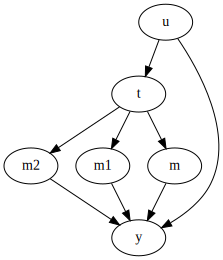

In [56]:
#Demonstrate for 3 adjusting variables
fd3 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.3, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.1,0.9), (1,): (0.8,0.2)}),
    "m": discrete_model(["t"], {(0,): (0.7, 0.3), (1,): (0.1, 0.9)}),
    "m1": discrete_model(["t"], {(0,): (0.6, 0.4), (1,): (0.45, 0.55)}),
    "m2": discrete_model(["t"], {(0,): (0.5, 0.5), (1,): (0.9, 0.1)}),
    "y": discrete_model(["m", "m1","m2", "u"], {
        (0, 0, 0, 0):(0.2,0.8),
        (0, 0, 0, 1):(0.1,0.9),
        (0, 0, 1, 0):(0.6,0.4),
        (0, 0, 1, 1):(0.7,0.3),
        (0, 1, 0, 0):(0.5,0.5),
        (0, 1, 0, 1):(0.1,0.9),
        (0, 1, 1, 0):(0.2,0.8),
        (0, 1, 1, 1):(0.5,0.5),
        (1, 0, 0, 0):(0.3,0.7),
        (1, 0, 0, 1):(0.9,0.1),
        (1, 0, 1, 0):(0.2,0.8),
        (1, 0, 1, 1):(0.3,0.7),
        (1, 1, 0, 0):(0.5,0.5),
        (1, 1, 0, 1):(0.4,0.6),
        (1, 1, 1, 0):(0.1,0.9),
        (1, 1, 1, 1):(0.7,0.3)
    }),
})

fd3.cgm.draw()

In [57]:
ate_frontdoor(fd3,"t","y")

-0.0530351408974733